<img src="tmva_logo.gif" height="20%" width="20%">

# TMVA Classification Example

## Declare Factory

Create the Factory class. Later you can choose the methods
whose performance you'd like to investigate. 

The factory is the major TMVA object you have to interact with. Here is the list of parameters you need to pass

 - The first argument is the base of the name of all the output
weightfiles in the directory weight/ that will be created with the 
method parameters 

 - The second argument is the output file for the training results
  
 - The third argument is a string option defining some general configuration for the TMVA session. For example all TMVA output can be suppressed by removing the "!" (not) in front of the "Silent" argument in the option string

In [1]:
TMVA::Tools::Instance();


auto outputFile = TFile::Open("Higgs_ClassificationOutput.root", "RECREATE");

TMVA::Factory factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" ); 

## Setup Dataset(s)

Define input data file and signal and background trees

In [2]:
TString inputFileName = "Higgs_data.root";

//TString inputFileName = "tmva_class_example.root";

auto inputFile = TFile::Open( inputFileName );

// --- Register the training and test trees

TTree *signalTree     = (TTree*)inputFile->Get("sig_tree");
TTree *backgroundTree = (TTree*)inputFile->Get("bkg_tree");

signalTree->Print();

******************************************************************************
*Tree    :sig_tree  : Signal Tree                                            *
*Entries :    10000 : Total =         1141446 bytes  File  Size =    1000730 *
*        :          : Tree compression factor =   1.13                       *
******************************************************************************
*Br    0 :lepton_pT : lepton_pT/F                                            *
*Entries :    10000 : Total  Size=      40761 bytes  File Size  =      30836 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.04     *
*............................................................................*
*Br    1 :lepton_eta : lepton_eta/F                                          *
*Entries :    10000 : Total  Size=      40768 bytes  File Size  =      29658 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.08     *
*...................................................

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input variables 

Define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In [3]:
TMVA::DataLoader * loader = new TMVA::DataLoader("dataset");

loader->AddVariable("m_jj");
loader->AddVariable("m_jjj");
loader->AddVariable("m_lv");
loader->AddVariable("m_jlv");
loader->AddVariable("m_bb");
loader->AddVariable("m_wbb");
loader->AddVariable("m_wwbb");

We set now the input data trees in the TMVA DataLoader class

In [4]:
// global event weights per tree (see below for setting event-wise weights)
Double_t signalWeight     = 1.0;
Double_t backgroundWeight = 1.0;
   
// You can add an arbitrary number of signal or background trees
loader->AddSignalTree    ( signalTree,     signalWeight     );
loader->AddBackgroundTree( backgroundTree, backgroundWeight );


// Set individual event weights (the variables must exist in the original TTree)
//    for signal    : factory->SetSignalWeightExpression    ("weight1*weight2");
//    for background: factory->SetBackgroundWeightExpression("weight1*weight2");
//loader->SetBackgroundWeightExpression( "weight" );

// Apply additional cuts on the signal and background samples (can be different)
TCut mycuts = ""; // for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
TCut mycutb = ""; // for example: TCut mycutb = "abs(var1)<0.5";

// Tell the factory how to use the training and testing events
//
// If no numbers of events are given, half of the events in the tree are used 
// for training, and the other half for testing:
//    loader->PrepareTrainingAndTestTree( mycut, "SplitMode=random:!V" );
// To also specify the number of testing events, use:

loader->PrepareTrainingAndTestTree( mycuts, mycutb,
                                    "nTrain_Signal=1000:nTrain_Background=1000:nTest_Signal=1000:nTest_Background=1000:"
                                    "SplitMode=Random:NormMode=NumEvents:!V" );



DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 10000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 10000 events


# Booking Methods

Here we book the TMVA methods. We book a Likelihood based on KDE, a Fischer discriminant and a BDT

In [5]:
// Likelihood ("naive Bayes estimator")
//factory.BookMethod(loader, TMVA::Types::kLikelihood, "Likelihood",
//                           "H:!V:TransformOutput:PDFInterpol=Spline2:NSmoothSig[0]=20:NSmoothBkg[0]=20:NSmoothBkg[1]=10:NSmooth=1:NAvEvtPerBin=50" );

// Use a kernel density estimator to approximate the PDFs
factory.BookMethod(loader, TMVA::Types::kLikelihood, "LikelihoodKDE",
                           "!H:!V:!TransformOutput:PDFInterpol=KDE:KDEtype=Gauss:KDEiter=Adaptive:KDEFineFactor=0.3:KDEborder=None:NAvEvtPerBin=50" ); 


// Fisher discriminant (same as LD)
factory.BookMethod(loader, TMVA::Types::kFisher, "Fisher", "H:!V:Fisher:VarTransform=None:CreateMVAPdfs:PDFInterpolMVAPdf=Spline2:NbinsMVAPdf=50:NsmoothMVAPdf=10" );


//Boosted Decision Trees
factory.BookMethod(loader,TMVA::Types::kBDT, "BDT",
                   "!V:NTrees=200:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" );

//Multi-Layer Perceptron (Neural Network)
factory.BookMethod(loader, TMVA::Types::kMLP, "MLP",
                   "!H:!V:NeuronType=tanh:VarTransform=N:NCycles=100:HiddenLayers=N+5:TestRate=5:!UseRegulator" );

Factory                  : Booking method: LikelihoodKDE
                         : 
Factory                  : Booking method: Fisher
                         : 
Factory                  : Booking method: BDT
                         : 
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree sig_tree
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree bkg_tree
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 1000
                         : Signal     -- testing events             : 1000
   

### Booking Deep Neural Network

Here we book the new DNN of TMVA. If using master version you can use the new DL method

In [6]:
bool useDL = true; 


#### 1. Define DNN layout

The DNN configuration os defined using a string. Note that whitespaces between characters are not allowed. 

We define first the DNN layout: 

- **input layout** :   this defines the input data format for the DNN as  ``input depth | height | width``. 
   In case of a dense layer as first layer the input layout should be  ``1 | 1 | number of input variables`` (features)
- **batch layout**  : this defines how are the input batch. It is related to input layout but not the same. 
   If the first layer is dense it should be ``1 | batch size ! number of variables`` (fetures)
   
   *(note the use of the character `|` as  separator of  input parameters for DNN layout)*
                 
- **layer layout** string defining the layer architecture. The syntax is  
   - layer type (e.g. DENSE, CONV, RNN)
   - layer parameters (e.g. number of units)
   - activation function (e.g  TANH, RELU,...)
   
     *the different layers are separated by the ``","`` *
                
#### 2. Define Trainining Strategy

We define here the training strategy parameters for the DNN. The parameters are separated by the ``","`` separator. 
One can then concatenate different training strategy with different parameters. The training strategy are separated by 
the ``"|"`` separator. 

 - Optimizer
 - Learning rate
 - Momentum (valid for SGD and RMSPROP)
 - Regularization and Weight Decay 
 - Dropout 
 - Max number of epochs 
 - Convergence steps. if the test error will not decrease after that value the training will stop
 - Batch size (This value must be the same specified in the input layout)
 - Test Repetitions (the interval when the test error will be computed) 


#### 3. Define general DNN options

We define the general DNN options concateneting in the final string the previously defined layout and training strategy.
Note we use the ``":"`` separator to separate the different higher level options, as in the other TMVA methods. 
In addition to input layout, batch layout and training strategy we add now: 

- Type of Loss function (e.g. cross entropy)
- Weight Initizalization (e.g XAVIER, XAVIERUNIFORM, NORMAL )
- Variable Transformation
- Type of Architecture (e.g. CPU, GPU, Standard)

We can then book the DL method using the built otion string
                

In [7]:
if (useDL) {  
     // Define DNN layout
     TString inputLayoutString = "InputLayout=1|1|7"; 
     TString batchLayoutString= "BatchLayout=1|100|7";
     TString layoutString ("Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR");
                                                                                                                                                                                    
      // Define Training strategies 
      // one can catenate several training strategies 
      TString training1("LearningRate=1e-3,Momentum=0.9,Repetitions=1,"
                        "ConvergenceSteps=10,BatchSize=100,TestRepetitions=1,"
                        "MaxEpochs=30,WeightDecay=1e-4,Regularization=None,"
                        "Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.");
 //     TString training2("LearningRate=1e-3,Momentum=0.9,Repetitions=1,"
 //                       "ConvergenceSteps=10,BatchSize=128,TestRepetitions=1,"
 //                       "MaxEpochs=20,WeightDecay=1e-4,Regularization=None,"
 //                       "Optimizer=SGD,DropConfig=0.0+0.0+0.0+0.");
  
      TString trainingStrategyString ("TrainingStrategy=");
      trainingStrategyString += training1; // + "|" + training2;

      // General Options.                                                                                                                                                                
      TString dnnOptions ("!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:"
                          "WeightInitialization=XAVIER");
      dnnOptions.Append (":"); dnnOptions.Append (inputLayoutString);
      dnnOptions.Append (":"); dnnOptions.Append (batchLayoutString);
      dnnOptions.Append (":"); dnnOptions.Append (layoutString);
      dnnOptions.Append (":"); dnnOptions.Append (trainingStrategyString);

      dnnOptions += ":Architecture=CPU";
      factory.BookMethod(loader, TMVA::Types::kDL, "DL_CPU", dnnOptions);

}

Factory                  : Booking method: DL_CPU
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER:InputLayout=1|1|7:BatchLayout=1|100|7:Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,Repetitions=1,ConvergenceSteps=10,BatchSize=100,TestRepetitions=1,MaxEpochs=30,WeightDecay=1e-4,Regularization=None,Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.:Architecture=CPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER:

## Train Methods

Here we train all the previously booked methods. 

In [8]:
factory.TrainAllMethods();

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_jj' <---> Output : variable 'm_jj'
                         : Input : variable 'm_jjj' <---> Output : variable 'm_jjj'
                         : Input : variable 'm_lv' <---> Output : variable 'm_lv'
                         : Input : variable 'm_jlv' <---> Output : variable 'm_jlv'
                         : Input : variable 'm_bb' <---> Output : variable 'm_bb'
                         : Input : variable 'm_wbb' <---> Output : variable 'm_wbb'
                         : Input : variable 'm_wwbb' <---> Output : variable 'm_wwbb'
TFHandler_Factory        : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
         

## Test  all methods

Here we test all methods using the test data set

In [9]:
factory.TestAllMethods();   

Factory                  : Test all methods
Factory                  : Test method: LikelihoodKDE for Classification performance
                         : 
LikelihoodKDE            : [dataset] : Evaluation of LikelihoodKDE on testing sample (2000 events)
                         : Elapsed time for evaluation of 2000 events: 0.00361 sec       
Factory                  : Test method: Fisher for Classification performance
                         : 
Fisher                   : [dataset] : Evaluation of Fisher on testing sample (2000 events)
                         : Elapsed time for evaluation of 2000 events: 0.000343 sec       
                         : Dataset[dataset] : Evaluation of Fisher on testing sample
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (2000 events)
                         : Elapsed time for evaluation of 2000 events: 0.0166 sec       

## Evaluate all methods

Here we evaluate all methods and compare their performances, computing efficiencies, ROC curves etc.. using both training and tetsing data sets. Several histograms are produced which can be examined with the TMVAGui or directly using the output file

In [10]:
factory.EvaluateAllMethods();

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: LikelihoodKDE
                         : 
LikelihoodKDE            : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_LikelihoodKDE  : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     m_jj:     1.0421    0.63432   [    0.20680     8.4241 ]
                         :    m_jjj:     1.0299    0.36763   [    0.44919     4.8921 ]
                         :     m_lv:     1.0458    0.13871   [    0.71894     2.4122 ]
                         :    m_jlv:     1.0075    0.40598   [    0.46907     4.7747 ]
                         :     m_bb:    0.98270    0.54045   [   0.079985     5.1638 ]
                         :    m_wbb:     1.0412    0.36707   [    0.46771     3.2929 ]
                         :   

## Plot ROC Curve
We enable JavaScript visualisation for the plots

In [11]:
//%jsroot on

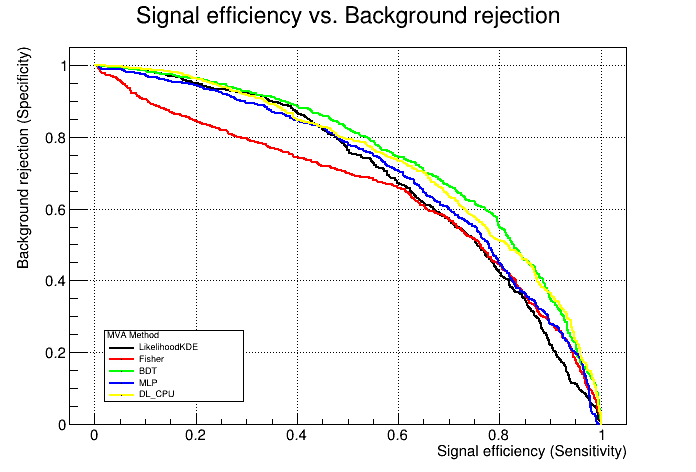

In [12]:
c1 = factory.GetROCCurve(loader);
c1->Draw();


####  Close outputfile to save all output information (evaluation result of methods)

In [13]:
outputFile->Close();